In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import math
import numba as nb
from testing_sample import *
import numpy as np

In [ ]:
f = Data_file(0)
f.read_data_of_hkl()


In [11]:
"""
  Auto-tuning (grid search) for peak detection parameters.
  Two modes:
   - Supervised: provide truth centers -> maximize F1 (with tolerance)
   - Unsupervised: no labels -> maximize a heuristic score with optional
     expected n_peaks

  This cell reuses the baseline pipeline and runs a grid over
    prominence, distance, Savitzky–Golay (window, polyorder).

  Outputs:
   - A table of top configs with metrics
   - A plot for the best config
   - CSV with all results

  You can paste this cell into your notebook and swap (x, y) for your data.
  If you have ground-truth centers, set truth_centers to a 1D array of positions
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve

try:
    from IPython.display import display
except Exception:
    display = print


In [12]:

"""
  Helper functions
"""
"""
  Even-odd info
"""
def make_odd(n):
    n = int(n)
    return n if n % 2 == 1 else n + 1
"""
  Gaussian peak
"""
def gaussian(x, mu, amp, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
"""
  Data generator - to be changed into real data
"""
def generate_signal_data(n=6000, seed=0):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, n)
    centers = np.array([0.12, 0.18, 0.21, 0.31, 0.38, 0.45, 0.505, 0.63, 0.71, 0.88])
    amps    = np.array([1.0, 0.55, 0.21, 0.9, 0.12, 1.2, 0.6, 0.46, 0.85, 0.7])
    sigmas  = np.array([0.006, 0.0095, 0.0045, 0.008, 0.065, 0.0065, 0.004, 0.095, 0.0055, 0.006])
    y_peaks = np.zeros_like(x)
    for c, a, s in zip(centers, amps, sigmas):
        y_peaks += gaussian(x, c, a, s)
    baseline = 0.15 + 0.2*x + 0.05*x**2 + 0.03*np.sin(2*np.pi*1.2*x)
    noise = 0.03 * rng.standard_normal(size=n)
    y = y_peaks + baseline + noise
    return x, y, centers


In [13]:
"""
  Statistical toolkit
"""
"""
  baseline estimation
"""
def baseline_als(y, lam=2e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * (D @ D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z
"""
  additional signal processing - Savitzky–Golay technique
"""
def detrend_and_smooth(x, y, sg_window=51, sg_poly=3):
    base = baseline_als(y)
    # Ensure valid SG window
    sg_window = make_odd(min(sg_window, len(y) - 1 - (1 - len(y) % 2)))
    y_detr = y - base
    y_smooth = savgol_filter(y_detr, window_length=sg_window, polyorder=sg_poly, mode="interp")
    return base, y_detr, y_smooth

In [14]:
"""
  Match peaks - useful for estimating the performane (peak finding
  efficiency etc.) and supervised studies
"""
def match_peaks(x, pred_idx, truth_centers, tol_abs=None, tol_frac_width=0.5, props=None):
    """
      Convert truth centers to indices
    """
    truth_idx = np.searchsorted(x, truth_centers)
    truth_idx = np.clip(truth_idx, 0, len(x) - 1)

    """
      Estimate a width in samples - important for proper comparison
      this will play the role of tolerances
    """
    if tol_abs is None:
        if props and "widths" in props and len(props["widths"]) > 0:
            tol_abs = np.median(props["widths"]) * tol_frac_width
        else:
            tol_abs = max(3, int(0.005 * len(x)))  # fallback ~0.5% of L
    tol_abs = int(max(1, np.round(tol_abs)))

    used_pred = set()
    tp = 0
    abs_errors = []
    for t in truth_idx:
        if len(pred_idx) == 0:
            continue
        diffs = np.abs(pred_idx - t)
        j = int(np.argmin(diffs))
        if diffs[j] <= tol_abs and j not in used_pred:
            used_pred.add(j)
            tp += 1
            abs_errors.append(int(diffs[j]))
    fp = int(len(pred_idx) - tp)
    fn = int(len(truth_idx) - tp)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    mae = float(np.mean(abs_errors)) if abs_errors else None
    return dict(tp=tp, fp=fp, fn=fn, precision=precision, recall=recall, f1=f1, mae=mae, tol_abs=tol_abs)

"""
  Efficiency for the unsupervised studies
"""
def unsupervised_score(n_peaks, prominences, expected_n=None, expected_range=None):
    prom = float(np.mean(prominences)) if len(prominences) else 0.0
    base = prom / np.sqrt(max(1, n_peaks))
    penalty = 0.0
    if expected_n is not None:
        penalty += 0.5 * abs(n_peaks - expected_n) / max(1, expected_n)
    if expected_range is not None:
        lo, hi = expected_range
        if n_peaks < lo:
            penalty += (lo - n_peaks) / max(1, lo)
        elif n_peaks > hi:
            penalty += (n_peaks - hi) / max(1, hi)
    return base - penalty



In [ ]:
"""
  Define the pipeline and run it!
"""


"""
  Prepare the data - first generate some synthetic input
  Change for the real deal later
"""
# x, y, truth = generate_signal_data(n=4000, seed=7)
x = f.x
y = f.counts
truth = f.two_theta
print("-->", len(truth))

"""
  Replace with your ground truth (np.array of x positions) or set to None
"""
truth_centers = truth
have_truth = truth_centers is not None


"""
  Define params serach grid
"""
sg_windows = [21, 31, 41, 51, 61, 81, 101]
sg_polys   = [2, 3]
prominences = [0.03, 0.05, 0.07, 0.09, 0.12]
distances   = [10, 15, 20, 30, 40]

"""
  General settings
"""
expected_n = None
expected_range = (5, 12)


"""
  Tune parameters
"""
records = []
for w in sg_windows:
    for p in sg_polys:
        base, y_detr, y_smooth = detrend_and_smooth(x, y, sg_window=w, sg_poly=p)
        for prom in prominences:
            for dist in distances:
                peaks, props = find_peaks(y_smooth, prominence=prom, distance=dist, rel_height=0.5)
                n = len(peaks)
                prom_arr = props.get("prominences", np.array([]))
                if have_truth:
                    metr = match_peaks(x, peaks, truth_centers, props=props)
                    score = metr["f1"]
                else:
                    score = unsupervised_score(n, prom_arr, expected_n=expected_n, expected_range=expected_range)
                    metr = {}
                rec = {
                    "sg_window": int(make_odd(w)),
                    "sg_poly": int(p),
                    "prominence": float(prom),
                    "distance": int(dist),
                    "n_peaks": int(n),
                    "score": float(score),
                    "mean_prominence": float(np.mean(prom_arr)) if len(prom_arr) else 0.0,
                    **metr
                }
                records.append(rec)

df = pd.DataFrame.from_records(records)

if have_truth:
    df["peaks_diff"] = np.abs(df["n_peaks"] - len(truth_centers))
    df_sorted = df.sort_values(by=["score", "mae", "peaks_diff"], ascending=[False, True, True]).reset_index(drop=True)
else:
    df_sorted = df.sort_values(by=["score", "mean_prominence", "n_peaks"], ascending=[False, False, True]).reset_index(drop=True)

# Show top rows and save CSV
display(df_sorted.head(12))
csv_path = "mnt/peak_grid_results.csv"
df_sorted.to_csv(csv_path, index=False)
print(f"Saved results to {csv_path}")


--> 28


C:\Users\nkurd\AppData\Local\Temp\ipykernel_6468\851680579.py:14: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


,sg_window,sg_poly,prominence,distance,n_peaks,score,mean_prominence,tp,fp,fn,precision,recall,f1,mae,tol_abs,peaks_diff
0,101,3,0.12,40,38,0.606061,34.896691,20,18,8,0.526316,0.714286,0.606061,4.250000,15,10
1,81,2,0.09,40,48,0.605263,31.777239,23,25,5,0.479167,0.821429,0.605263,5.260870,15,20
2,81,2,0.12,40,48,0.605263,31.777239,23,25,5,0.479167,0.821429,0.605263,5.260870,15,20
3,81,2,0.05,40,49,0.597403,31.130196,23,26,5,0.469388,0.821429,0.597403,5.260870,15,21
4,81,2,0.07,40,49,0.597403,31.130196,23,26,5,0.469388,0.821429,0.597403,5.260870,15,21
5,81,3,0.09,40,49,0.597403,31.192325,23,26,5,0.469388,0.821429,0.597403,5.260870,15,21
6,81,3,0.12,40,49,0.597403,31.192325,23,26,5,0.469388,0.821429,0.597403,5.260870,15,21
7,101,2,0.12,40,39,0.597015,33.641109,20,19,8,0.512821,0.714286,0.597015,4.650000,15,11
8,101,2,0.12,30,43,0.591549,30.523533,21,22,7,0.488372,0.750000,0.591549,5.000000,15,15
9,81,3,0.05,40,50,0.589744,30.569921,23,27,5,0.460000,0.821429,0.589744,5.260870,15,22


Saved results to mnt/peak_grid_results.csv


C:\Users\nkurd\AppData\Local\Temp\ipykernel_6468\851680579.py:14: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


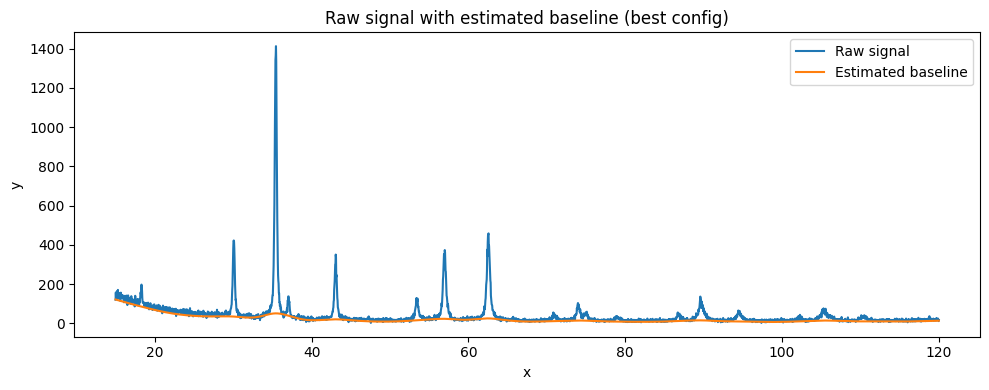

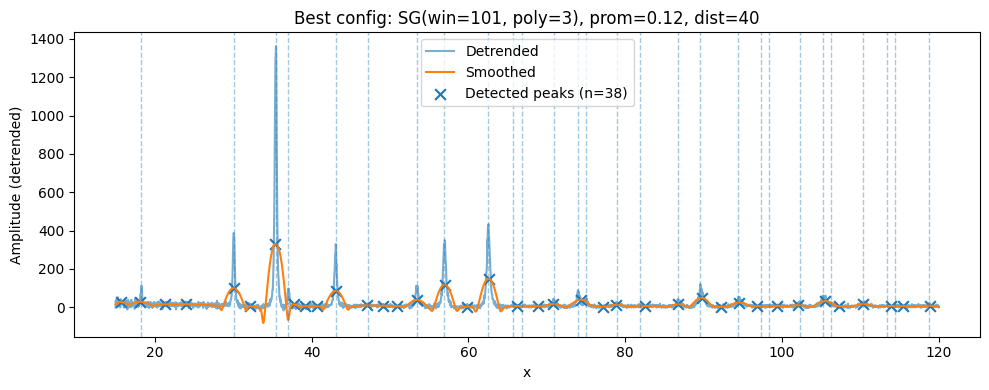

{'csv_path': 'mnt/peak_grid_results.csv',
 'best_config': {'sg_window': 101,
  'sg_poly': 3,
  'prominence': 0.12,
  'distance': 40},
 'n_detected': 38}

In [18]:
"""
  Plots and visualisations
"""
top = df_sorted.iloc[0]
best_w = int(top["sg_window"])
best_p = int(top["sg_poly"])
best_prom = float(top["prominence"])
best_dist = int(top["distance"])

base, y_detr, y_smooth = detrend_and_smooth(x, y, sg_window=best_w, sg_poly=best_p)
peaks, props = find_peaks(y_smooth, prominence=best_prom, distance=best_dist, rel_height=0.5)

plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Raw signal")
plt.plot(x, base, label="Estimated baseline")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Raw signal with estimated baseline (best config)")
plt.legend()
best_fig1 = "mnt/grid_best_raw_baseline.png"
plt.tight_layout()
plt.savefig(best_fig1, dpi=140, bbox_inches="tight")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x, y_detr, label="Detrended", alpha=0.6)
plt.plot(x, y_smooth, label="Smoothed")
plt.scatter(x[peaks], y_smooth[peaks], marker="x", s=60, label=f"Detected peaks (n={len(peaks)})")
if have_truth:
    for c in truth_centers:
        plt.axvline(c, linestyle="--", linewidth=1, alpha=0.4)
plt.xlabel("x")
plt.ylabel("Amplitude (detrended)")
plt.title(f"Best config: SG(win={best_w}, poly={best_p}), prom={best_prom}, dist={best_dist}")
plt.legend()
best_fig2 = "mnt/grid_best_detrended_smoothed.png"
plt.tight_layout()
plt.savefig(best_fig2, dpi=140, bbox_inches="tight")
plt.show()

summary = {
    "csv_path": csv_path,
    "best_config": dict(sg_window=best_w, sg_poly=best_p, prominence=best_prom, distance=best_dist),
    "n_detected": int(len(peaks))
}
summary